In [191]:
import scipy.io as sio
import numpy as np, scipy.io
import matplotlib.pyplot as plt
from numpy.random import seed
#fix seed for np
seed(1)
import tensorflow as tf
#fix seed for tf
tf.set_random_seed(2)
from keras.layers import Input, Dense, Lambda, Layer, Dropout
from keras.models import Model
from keras import backend as K
from keras import metrics
import h5py
from keras import regularizers, optimizers
from joblib import Parallel,delayed

In [192]:
def ismember(a, b):
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    return [bind.get(itm, None) for itm in a]  # None can be replaced by any other "not in b" value

def trustw_parallel(encode_decode,index,location,kn):
    N = np.size(index)  # total
    print("N {}".format(N))
    d = np.zeros((N,N),dtype='float32' )
    d_cov = np.zeros((N,N),dtype='float32' )

    for qq in range(0, N):
        for ww in range(0, N):
            #d[qq, ww] = np.linalg.norm(location[qq, :] - location[ww, :], 2)
            d[qq, ww] = np.sqrt(np.power(location[qq, 0] - location[ww, 0], 2) + np.power(location[qq, 1] - location[ww, 1], 2))
            d_cov[qq, ww] = np.sqrt(np.power(encode_decode[qq, 0] - encode_decode[ww, 0], 2) + np.power( encode_decode[qq, 1] - encode_decode[ww, 1], 2))
            #d_cov[qq, ww]= np.linalg.norm(encode_decode[qq, :] - encode_decode[ww, :], 2)
    d[d == 0] = np.inf;
    d_cov[d_cov == 0] = np.inf;

    inds = np.argsort(d, kind='mergesort');
    inds_cov = np.argsort(d_cov, kind='mergesort');

    result=Parallel(n_jobs=4)(delayed(trustw3)(k=k,inds=inds,inds_cov=inds_cov,N=N) for k in kn)
    result=np.asmatrix(result)
    tw=np.asarray(result[:,0])
    ct=np.asarray(result[:,1])
    kn=np.asarray(result[:,2])
    trustworthiness = 1 -  2 * tw / (N * kn * (2 * N - 3 * kn - 1))
    continuity = 1 - 2 * ct / (N * kn * (2 * N - 3 * kn - 1))
    return trustworthiness, continuity

def trustw3(k, inds, inds_cov,  N):
    tt=0
    cc=0
    for i in range(0, N):
        Uki = np.intersect1d(inds_cov[i, 0:k], inds[i, k:])
        rankUki = ismember(Uki, inds[i, :])
        rankUki = rankUki + np.ones(np.size(rankUki))
        twi = np.sum(np.asarray(rankUki) - k)
        tt = tt + twi

        Vki = np.intersect1d(inds_cov[i, k:], inds[i, 0:k])
        rankVki = ismember(Vki, inds_cov[i, :])
        rankVki = rankVki + np.ones(np.size(rankVki))
        cti = np.sum(np.asarray(rankVki) - k)
        cc=cc + cti
    return np.transpose(tt), np.transpose(cc), np.transpose(k)

In [193]:
#early stopping callback
from keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=7,verbose=1, mode='auto')
callback_list=[earlystop]

#loss function
def vae_loss(x,x_hat):
    xent_loss = metrics.mean_squared_error(x, x_hat)
    return xent_loss #+ xent_loss2

In [194]:
##read data from .mat file
# filename='./data/qd_LOS_32_3GPPUMi_15k_SC5.mat'
# Data = h5py.File(filename, 'r')

filename = './data/qd_LOS_32_3GPPUMi_15k_SC5.mat'
Data = sio.loadmat(filename)
Data_num = 10000
# print(Data)
#train_X = np.transpose(np.asmatrix(Data['D'].value.view()).astype('float32'))
#input data
train_X = (np.asmatrix(Data['h_coeff_real']).astype('float32')).T[:Data_num,:]
#indices of the users
index = (Data['index']).astype('int16')[:,:Data_num]
#locations of users
location = Data['positions'].astype('float64').T[:Data_num,:]

print(train_X.shape, location.shape,index.shape)
print(index)

(10000, 64) (10000, 2) (1, 10000)
[[    1     2     3 ...  9998  9999 10000]]


In [195]:
##parameters
original_dim = np.size(train_X,1)
print(original_dim)
n_hidden_2 = 500  # 2nd layer num features
n_hidden_3 = 100  # 3nd layer num features
n_hidden_4 = 50  # 4th layer num features
n_hidden_5 = 20

#length of the embedding
interim = 2
#batch size
batch_size = 100 ### we need to make sure its value less than the number of one specific value? I still do not figure out what is it
#number of epochs
epochs = 100


#define activation functions for each layer
act1 = 'tanh'
act2 = 'tanh'
act3 = 'softplus'
act4 = 'tanh'

##encoder
x = Input(batch_shape=(batch_size, original_dim))
print("x.shape{}".format(x.shape))
h1 = Dense(n_hidden_2, activation=act1 )(x)  # relu
h2 = Dense(n_hidden_3, activation=act2 )(h1)  # relu
h3 = Dense(n_hidden_4, activation=act3 )(h2)  # relu
h = Dense(n_hidden_5, activation=act4 )(h3)  # relu
z = Dense(interim,kernel_regularizer=regularizers.l2(1e-2))(h) #2d output w/ act reg 1e-4
print("z.shape{}".format(z.shape))
#
##decoder
_h_decoded = Dense(n_hidden_5 ,activation='relu')(z)  # relu/sigmoid
_h_decoded1 = Dense(n_hidden_4, activation=act4 )(_h_decoded)
_h_decoded2 = Dense(n_hidden_3, activation=act3 )(_h_decoded1)
_h_decoded3 = Dense(n_hidden_2, activation=act2 )(_h_decoded2)
print(_h_decoded3.shape)
x_hat = Dense(original_dim )(_h_decoded3)

print(x_hat.shape)

64
x.shape(100, 64)
z.shape(100, 2)
(100, 500)
(100, 64)


In [196]:
print("x.shape{}".format(x.shape))

x.shape(100, 64)


In [197]:
# end-to-end autoencoder
vae = Model(x, x_hat)
print("x.shape{}".format(x.shape))
encoder = Model(x, z)
## set optimizer
rms=optimizers.rmsprop(decay=1e-3,lr=0.001)
vae.compile(optimizer='rmsprop', loss=vae_loss)

#no test data
x_train = train_X; #(64, 15000)
x_test = train_X;
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) #(64, 15000)
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#train AE
vae.fit(x_train, x_train,
        shuffle=False,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=callback_list,
        verbose=1)

#get embeddings
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

#save data to a .mat file
#a = {}
#a['encoded'] = x_test_encoded
#scipy.io.savemat('tosaid', a)

x.shape(100, 64)
Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 6s 559us/step - loss: 0.0439 - val_loss: 0.0220
Epoch 2/100
10000/10000 [==============================] - 2s 191us/step - loss: 0.0129 - val_loss: 0.0068
Epoch 3/100
10000/10000 [==============================] - 1s 142us/step - loss: 0.0042 - val_loss: 0.0019
Epoch 4/100
10000/10000 [==============================] - 2s 235us/step - loss: 9.6200e-04 - val_loss: 3.2475e-04
Epoch 5/100
10000/10000 [==============================] - 2s 198us/step - loss: 1.1305e-04 - val_loss: 1.0062e-05
Epoch 6/100
10000/10000 [==============================] - 2s 169us/step - loss: 5.4353e-06 - val_loss: 3.9872e-06
Epoch 7/100
10000/10000 [==============================] - 2s 196us/step - loss: 2.4798e-06 - val_loss: 2.0973e-06
Epoch 8/100
10000/10000 [==============================] - 2s 210us/step - loss: 1.7989e-06 - val_loss: 1.3245e-06
Epoch 9/100
10000/10000 [============

In [198]:
print(x_test_encoded.shape)
print(type(encoder))


(10000, 2)
<class 'keras.engine.training.Model'>


(10,)
N 10000


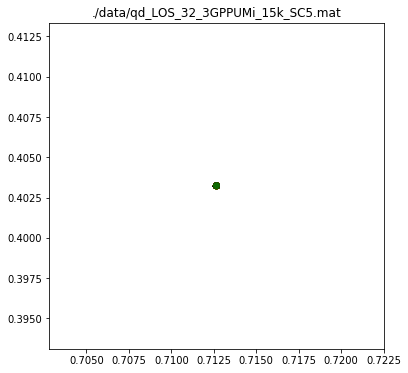

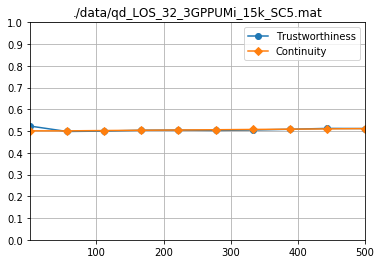

In [199]:
#plot embeddings
plt.figure(figsize=(6, 6))
color1=(location[:,0]-max(location[:,0]))/-np.ptp(location[:,0])
color2 = (location[:, 1] - max(location[:, 1])) / -np.ptp(location[:, 1])
color3 = np.zeros(np.size(color2))
colorMap = [color2 ,color1 , color3]

print(kn.shape)

# cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r
# sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)

plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],c=np.transpose(colorMap))
#plt.colorbar()
plt.title(filename)

#number of neighbors for trustworthiness and continuity
kn = (np.floor(np.linspace(1, np.round(np.size(x_test_encoded, 0) * 0.05), 10))).astype(int)
#run tw/ct function in parallel
trustworthiness,continuity=trustw_parallel(x_test_encoded, index, location, kn)


#plot tw/ct
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
plt.plot(kn,trustworthiness,label="Trustworthiness",marker="o")
plt.plot(kn,continuity,label="Continuity",marker="D")
##plot best results
ax.set_yticks(np.linspace(0,1,11))
plt.axis([1, np.max(kn), 0, 1])
plt.grid()
plt.title(filename)
plt.legend()

In [200]:
#save whole model
model_json = vae.to_json()
with open("model_"+filename+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5 and save
vae.save_weights("model_"+filename+".h5")

#save only encoder
model_json = encoder.to_json()
with open("encoder_" +filename +".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights of encoder to HDF5 and save
encoder.save_weights("encoder_"+filename+".h5")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'model_./data/qd_LOS_32_3GPPUMi_15k_SC5.mat.json'